In [77]:
%store -r ingest_create_athena_db_passed



In [78]:
import boto3
import sagemaker

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Setting up the session and connections

In [79]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
from pyathena import connect

In [80]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

# Assigning variables and checking tables

In [81]:
#database name and table
database_name = "oneclickdb"

table_1 = "aisles_tab"
table_2= "departments_tab"
table_3= "order_prior_tab"
table_4= "order_train_tab"
table_5= "orders_tab"
table_6= "products_tab"

In [82]:
count_t1 = """SELECT COUNT (*) FROM {}.{}""".format(database_name,table_1 )

count1= pd.read_sql(count_t1, conn)
count1

,_col0
0,134


In [83]:
count_t2 = """SELECT COUNT (*) FROM {}.{}""".format(database_name,table_2 )

count2= pd.read_sql(count_t2, conn)
count2

,_col0
0,21


In [84]:
count_t3 = """SELECT COUNT (*) FROM {}.{}""".format(database_name,table_3 )

count3= pd.read_sql(count_t3, conn)
count3

,_col0
0,32434489


In [85]:
count_t5 = """SELECT COUNT (*) FROM {}.{}""".format(database_name,table_5 )

count5= pd.read_sql(count_t5, conn)
count5

,_col0
0,3421083


In [86]:
count_t6 = """SELECT COUNT (*) FROM {}.{}""".format(database_name,table_6 )

count6= pd.read_sql(count_t6, conn)
count6

,_col0
0,49688


# Set Seaborn Parameters

In [87]:
sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

# Helper Code to Display Values on Bars


In [88]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

# Busiest day of the week

In [89]:
exploration_1 = """select 
  count(order_id) as total_orders, 
  (case 
     when order_dow = '0' then 'Sunday'
     when order_dow = '1' then 'Monday'
     when order_dow = '2' then 'Tuesday'
     when order_dow = '3' then 'Wednesday'
     when order_dow = '4' then 'Thursday'
     when order_dow = '5' then 'Friday'
     when order_dow = '6' then 'Saturday'              
   end) as day_of_week 
  from {}.{}  
 group by order_dow 
 order by total_orders desc """.format(database_name,table_5)



df_1= pd.read_sql(exploration_1, conn)
df_1.head(5)



,total_orders,day_of_week
0,600905,Sunday
1,587478,Monday
2,467260,Tuesday
3,453368,Friday
4,448761,Saturday


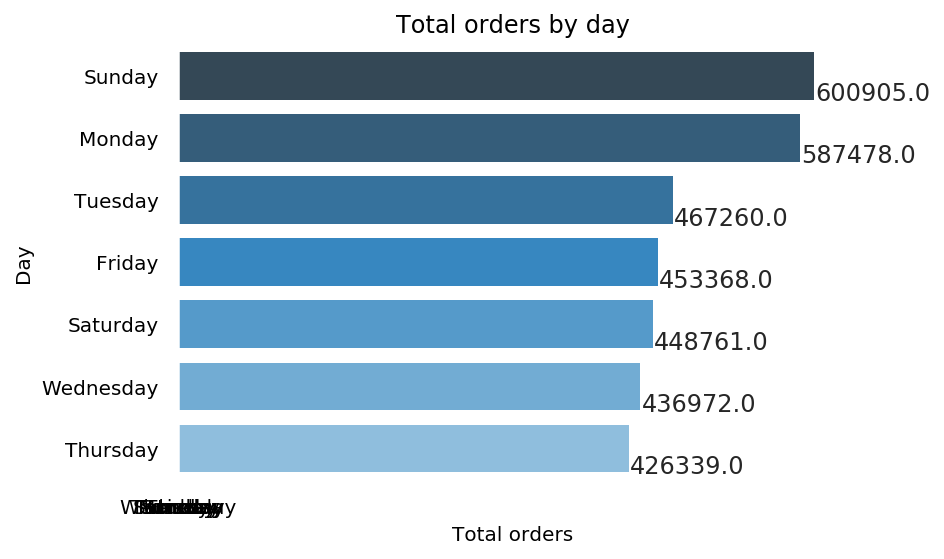

In [90]:
# Create plot


barplot = sns.barplot(x="total_orders",y="day_of_week", data= df_1, saturation=1, palette="Blues_d")

sns.set(rc={"figure.figsize": (20.0, 10.0)}) 

# Set title and x-axis ticks
plt.title("Total orders by day")
plt.xticks([1, 2, 3, 4, 5, 6, 7], ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday","Friday", "Saturday"])

# code to show actual values afters bars
show_values_barplot(barplot, 0.1)

plt.xlabel("Total orders")
plt.ylabel("Day")



# Show graphic
plt.show(barplot)

# Most Busy Hours 



In [91]:
exploration_1_1 =  """Select 
  count(order_id) as total_orders, 
  order_hour_of_day as hour 
  from oneclickdb.orders_tab 
 group by order_hour_of_day 
 order by order_hour_of_day"""

df_1_1= pd.read_sql(exploration_1_1, conn)

#df_1_1



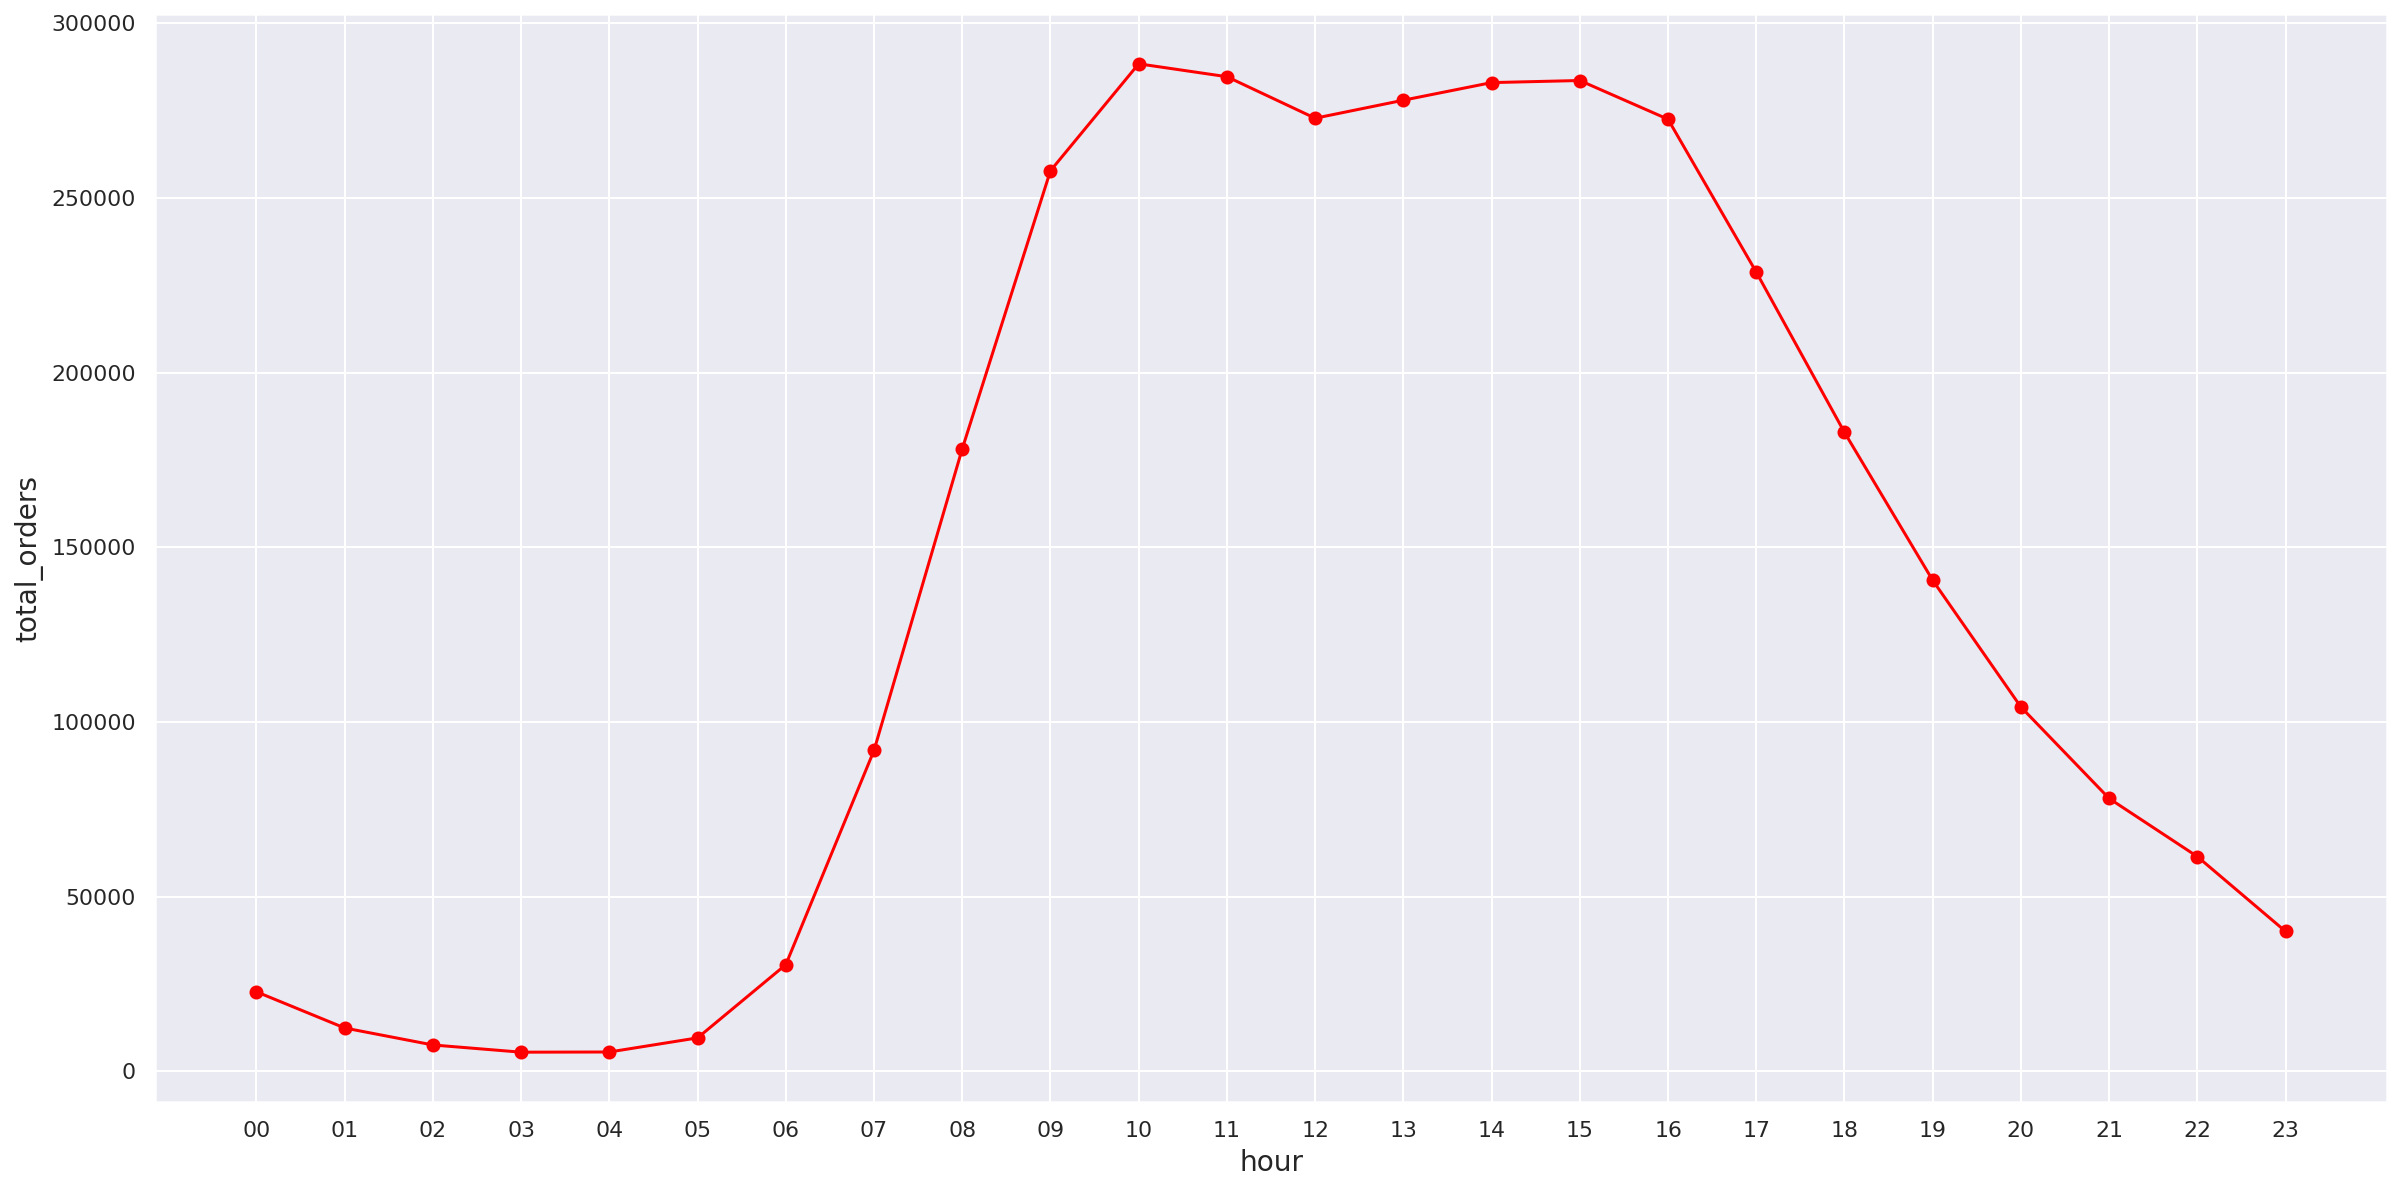

In [92]:
import matplotlib.pyplot as plt

plt.plot(df_1_1['hour'], df_1_1['total_orders'], color='red', marker='o')
# plt.title('Unemployment Rate Vs Year', fontsize=14)
plt.ylabel('total_orders', fontsize=14)
plt.xlabel('hour', fontsize=14)
plt.grid(True)
plt.show()

# Total product ordered per department

In [93]:
exploration_2 = """select countbydept.*
  from (
  select department_id, count(1) as counter
    from oneclickdb.products_tab
   group by department_id
   order by counter asc 
  ) as maxcount
inner join (
  select
    d.department_id,
    d.department,
    count(1) as products
    from oneclickdb.departments_tab d
      inner join oneclickdb.products_tab p
         on p.department_id = d.department_id
   group by d.department_id, d.department 
   order by products desc
  ) countbydept 

  on countbydept.products = maxcount.counter"""

df_2= pd.read_sql(exploration_2, conn)

df_2

,department_id,department,products
0,18,babies,938
1,5,alcohol,964
2,6,international,1049
3,4,produce,1642
4,17,household,2839
5,1,frozen,3770
6,10,bulk,52
7,10,bulk,52
8,10,bulk,52
9,2,other,524


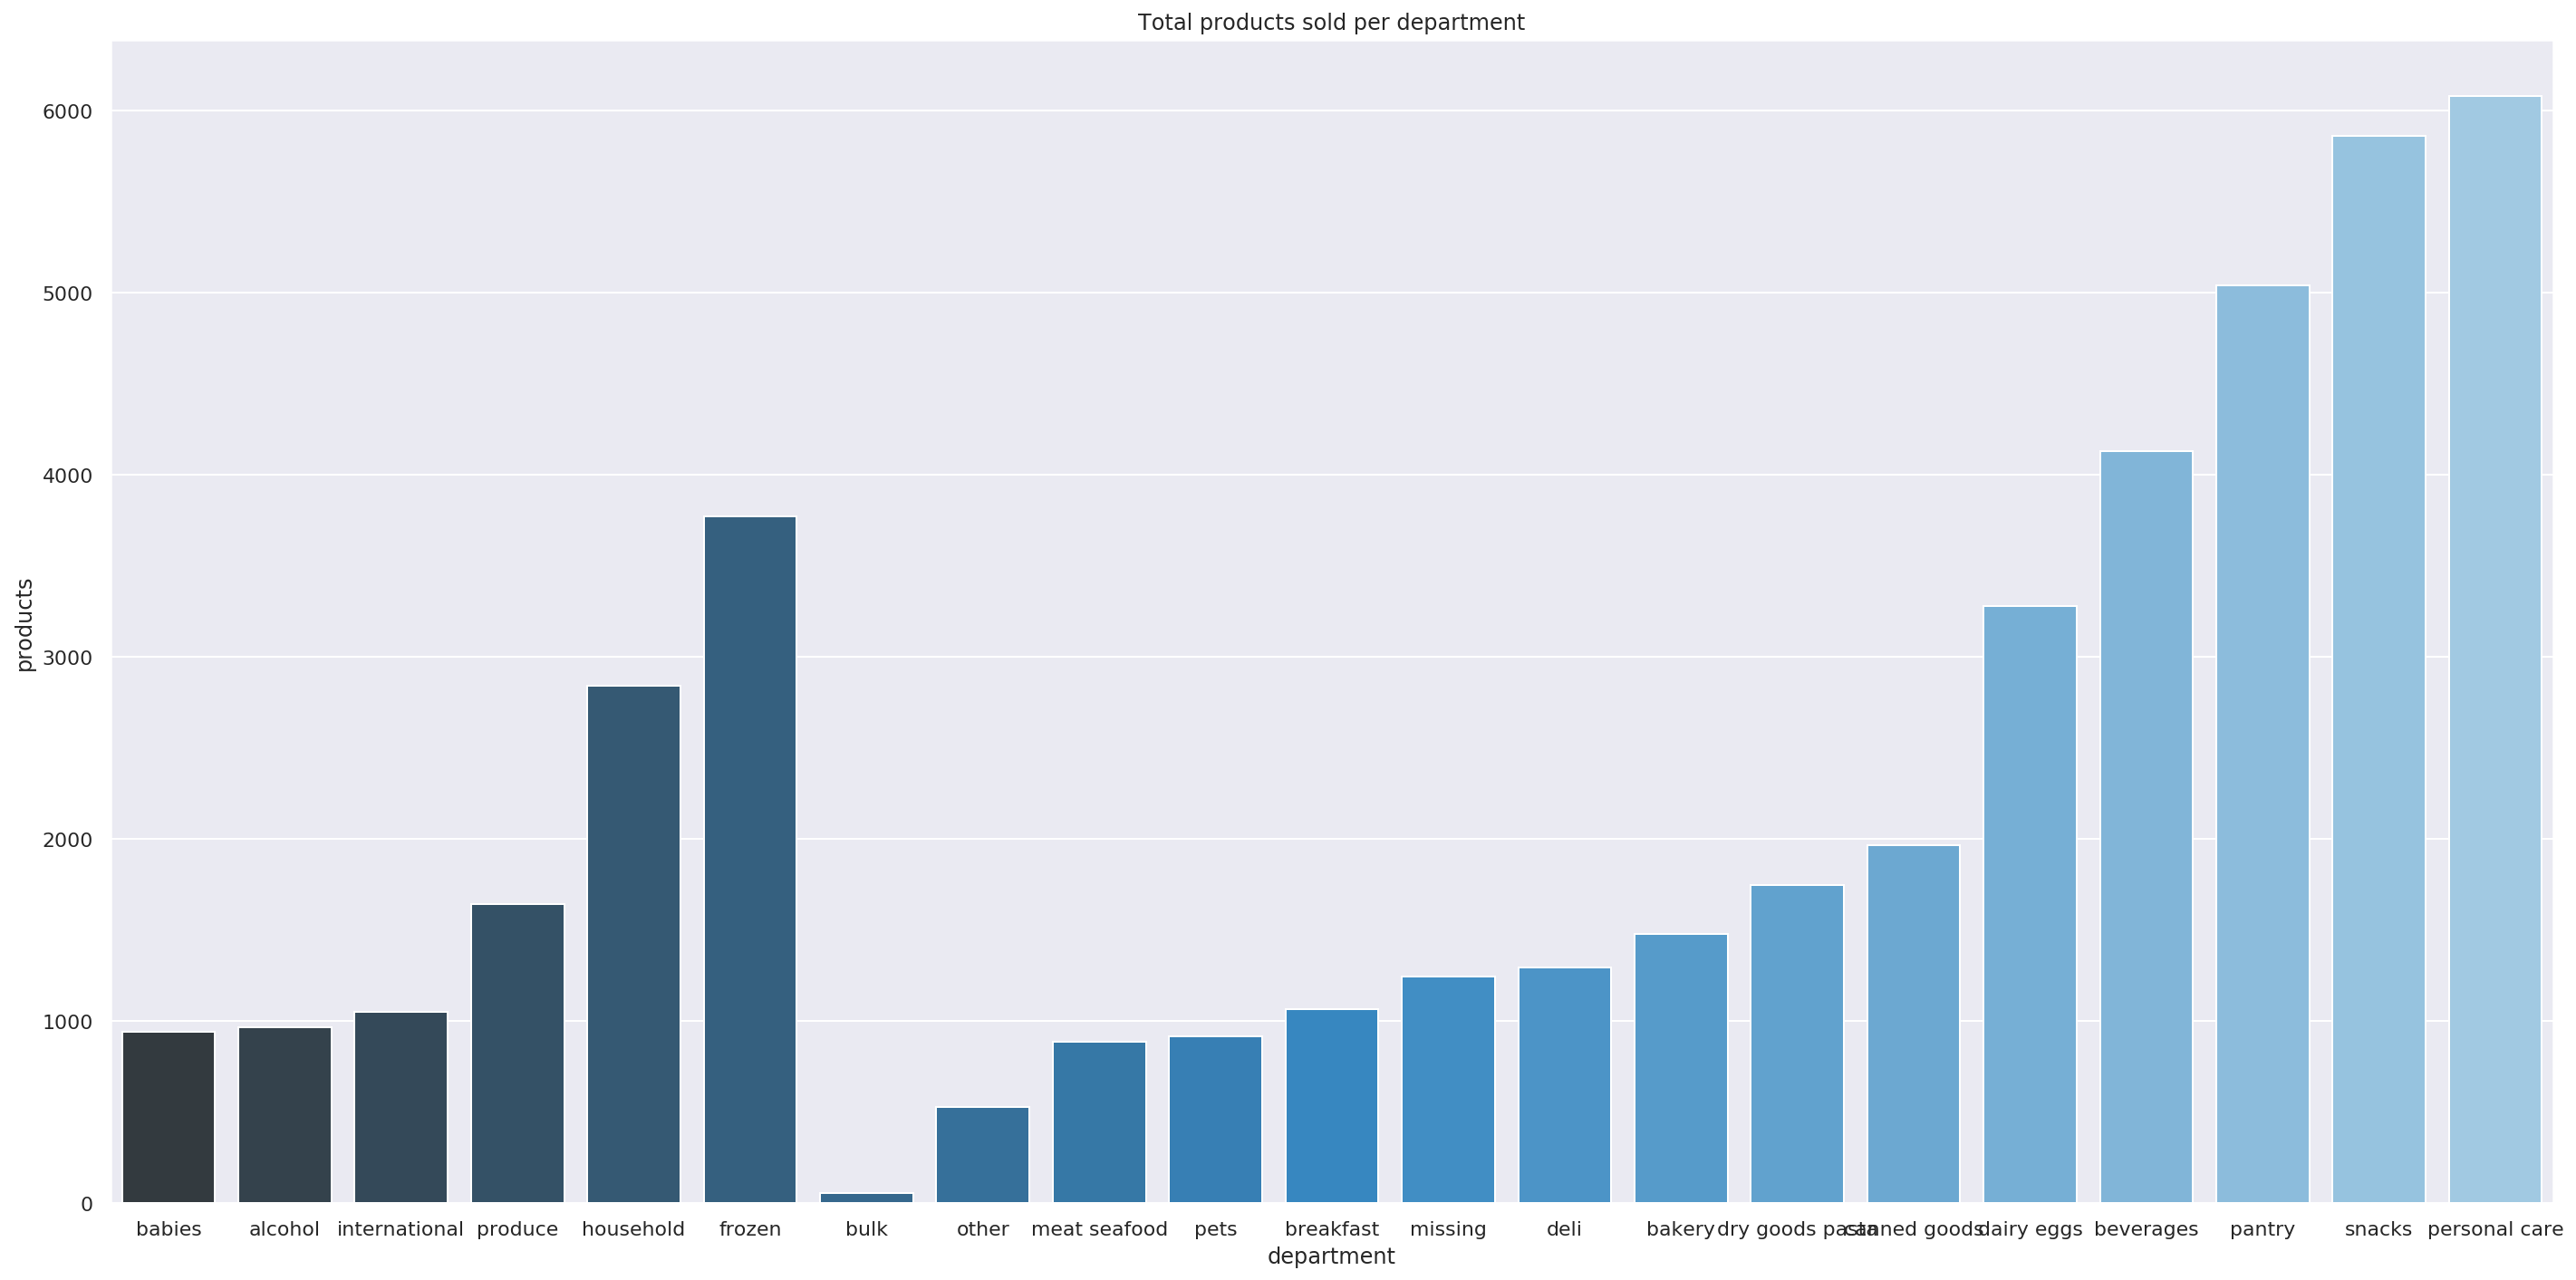

In [94]:
# Create plot
barplot = sns.barplot(x="department",y="products", data= df_2, saturation=1, palette="Blues_d")


sns.set(rc={"figure.figsize": (20.0, 10.0)})

# Set title and x-axis ticks
plt.title("Total products sold per department")
plt.xticks()

# code to show actual values afters bars


plt.xlabel("department")
plt.ylabel("products")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

# Number of orders per users.

In [95]:

exploration_3 = """ SELECT user_id,
COUNT (order_id) as orders 

FROM oneclickdb.orders_tab 
GROUP BY user_id 
ORDER BY orders desc"""


df_3= pd.read_sql(exploration_3, conn)

df_3.head(5)



,user_id,orders
0,123245,100
1,25422,100
2,202272,100
3,35190,100
4,130036,100


# Most purchased 20 product

In [96]:

exploration_4 = """SELECT count(opp.order_id) as orders, p.product_name 
  FROM oneclickdb.order_prior_tab opp, oneclickdb.products_tab p
  where p.product_id = opp.product_id 
  group by product_name 
  order by orders desc 
  limit 20"""

df_4= pd.read_sql(exploration_4, conn)

df_4



,orders,product_name
0,472565,Banana
1,379450,Bag of Organic Bananas
2,264683,Organic Strawberries
3,241921,Organic Baby Spinach
4,213584,Organic Hass Avocado
5,176815,Organic Avocado
6,152657,Large Lemon
7,142951,Strawberries
8,140627,Limes
9,137905,Organic Whole Milk


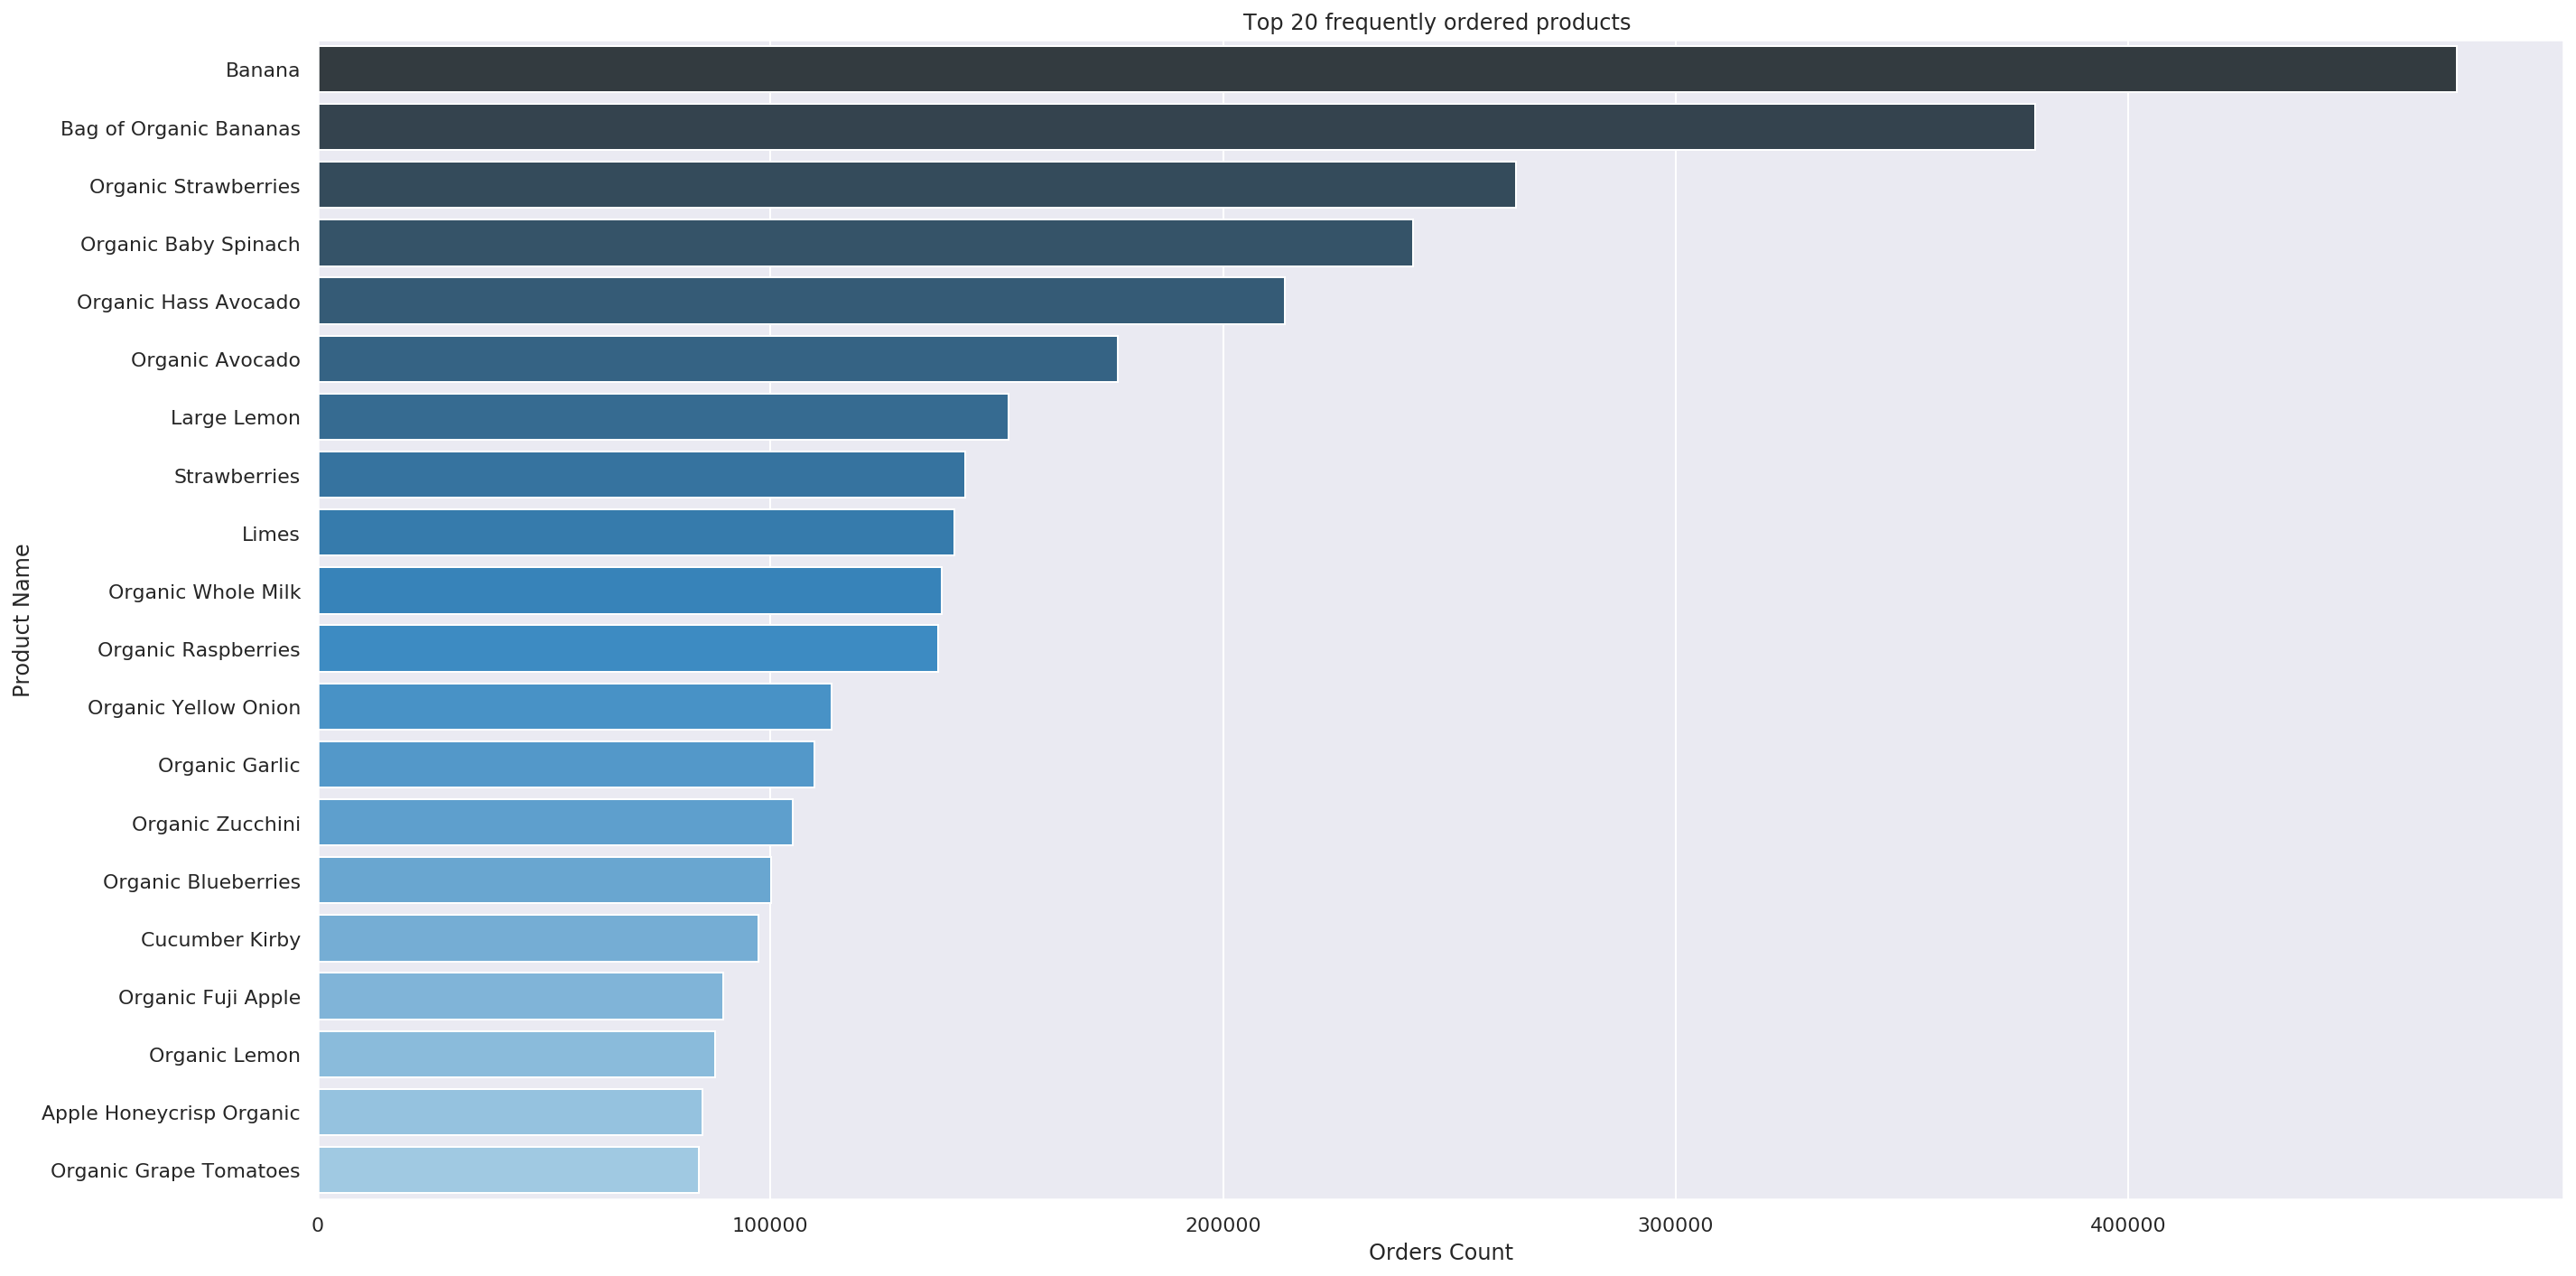

In [97]:
# Create plot
barplot = sns.barplot(x="orders",y="product_name", data= df_4, saturation=1, orient = 'h',palette="Blues_d")


sns.set(rc={"figure.figsize": (20.0, 10.0)})

# Set title and x-axis ticks
plt.title("Top 20 frequently ordered products ")
plt.xticks()

# code to show actual values afters bars


plt.ylabel("Product Name")
plt.xlabel("Orders Count")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

# Frequently Reordered Products

In [98]:

stat= """
SELECT product_name,
         COUNT(*) AS reordered_count
FROM oneclickdb.products_tab p
INNER JOIN oneclickdb.order_prior_tab opp ON p.product_id = opp.product_id
WHERE reordered = '1'
GROUP BY  product_name 
order by reordered_count desc 
LIMIT 15
"""


df_random= pd.read_sql(stat, conn)

df_random




,product_name,reordered_count
0,Banana,398609
1,Bag of Organic Bananas,315913
2,Organic Strawberries,205845
3,Organic Baby Spinach,186884
4,Organic Hass Avocado,170131
5,Organic Avocado,134044
6,Organic Whole Milk,114510
7,Large Lemon,106255
8,Organic Raspberries,105409
9,Strawberries,99802


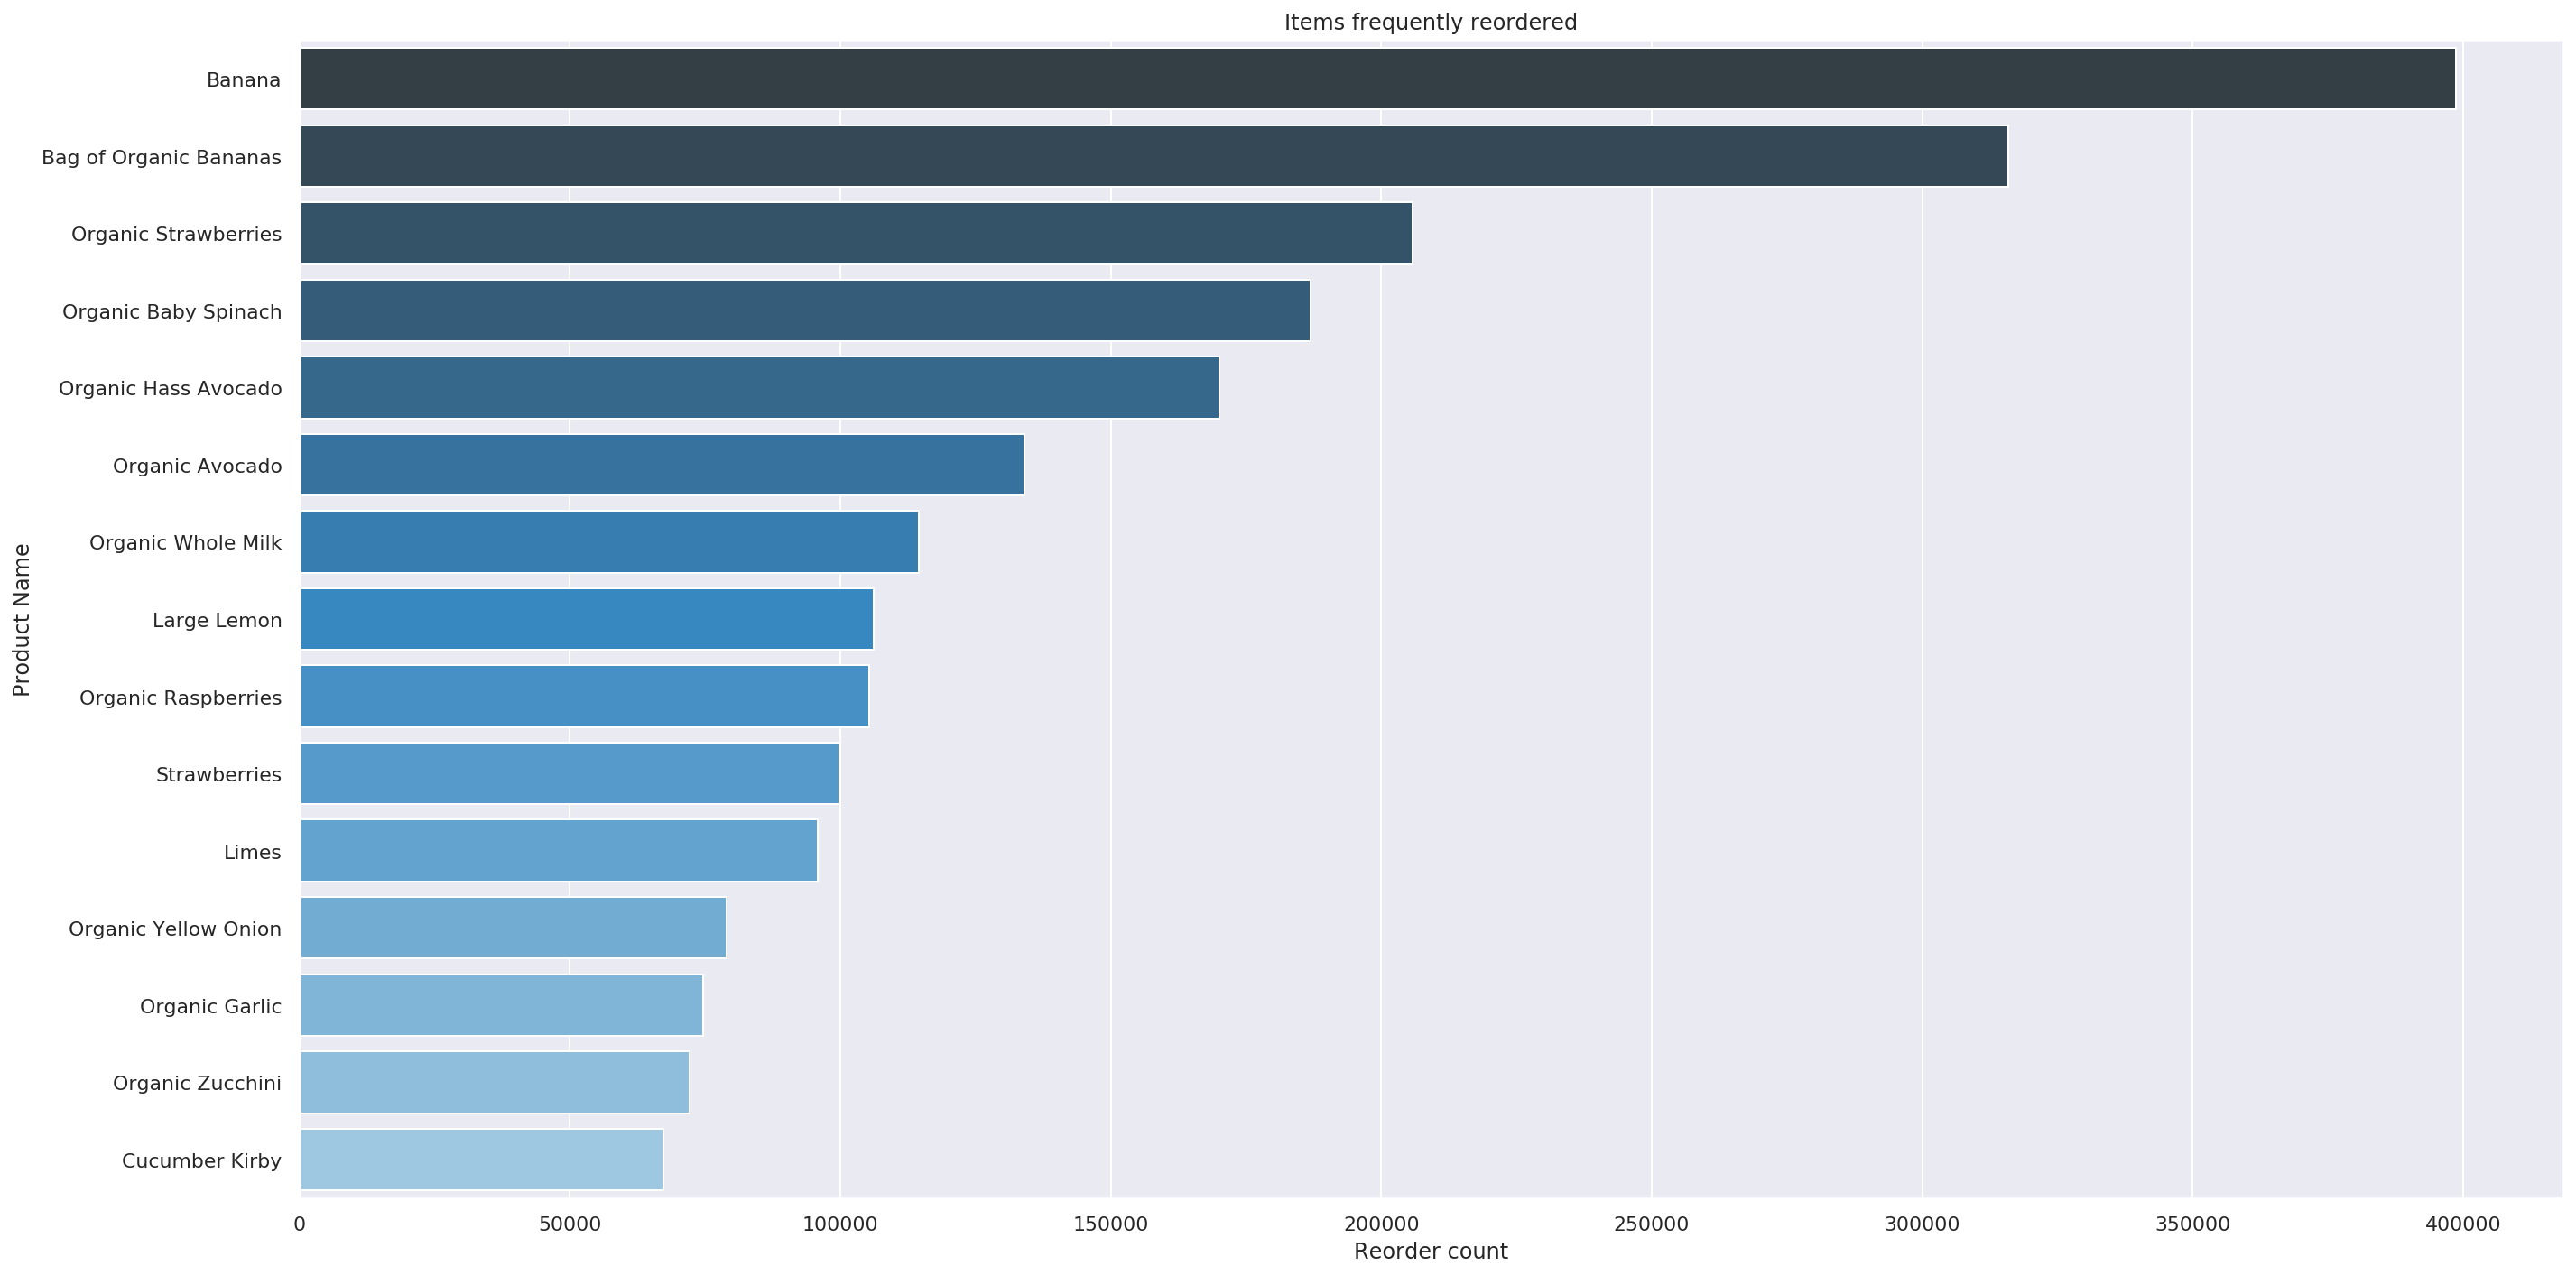

In [99]:
# Create plot
barplot = sns.barplot(x="reordered_count",y="product_name", data= df_random, saturation=1,palette="Blues_d")


sns.set(rc={"figure.figsize": (20.0, 10.0)})

# Set title and x-axis ticks
plt.title("Items frequently reordered")
plt.xticks()

# code to show actual values afters bars


plt.xlabel("Reorder count")
plt.ylabel("Product Name")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)